In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def data_load():
    response_file_path = '/content/drive/MyDrive/Sparse_PUFs/train_responses.dat'
    challenge_file_path = '/content/drive/MyDrive/Sparse_PUFs/train_challenges.dat'
    response_file = open(response_file_path, "r")
    response_data = list(response_file.read().split("\n"))
    response_values = []
    for value in response_data:
        if value:
            x = float(value)
            response_values.append(x)

    challenge_file = open(challenge_file_path, "r")
    challenge_data = list(challenge_file.read().split("\n"))
    challenge_values = []
    for line in challenge_data:
        challenge_line = []
        if line:
            parts = line.split(" ")
            for part in parts:
                if part.isdigit():
                    challenge_line.append(part)
        else:
            continue
        challenge_values.append(challenge_line)

    return np.asarray(challenge_values, dtype=float), np.asarray(response_values)


In [4]:
challenges, responses = data_load()
responses

array([1852.119682, 2103.222591, 2121.447663, ..., 2026.056949,
       2100.444096, 1988.291136])

In [5]:
def train_test_split(data, targets, test_size, random_state=None):
    np.random.seed(random_state)
    num_samples = len(data)
    num_test_samples = int(num_samples * test_size)
    shuffled_indices = np.random.permutation(num_samples)

    train_indices = shuffled_indices[:-num_test_samples]
    test_indices = shuffled_indices[-num_test_samples:]

    X_train = data[train_indices]
    y_train = targets[train_indices]
    X_test = data[test_indices]
    y_test = targets[test_indices]

    return X_train, X_test, y_train, y_test


In [6]:
# Perform dataset splitting, e.g., using train-test split
X_train, X_val, y_train, y_val = train_test_split(challenges, responses, test_size=0.2, random_state=None)
y_train.shape


(1280,)

In [7]:
def compute_rho_j(X, y, w, j):
    X_k = np.delete(X, j, axis=1)  # Remove the j variable i.e., j column
    w_k = np.delete(w, j)  # Remove the weight j
    predict = np.matmul(X_k, w_k.T)
    residual = y - predict  # Calculate residual as y - predict
    X_j = X[:, j]  # m*1 vector
    rho_j = np.dot(X_j, residual)
    return rho_j


In [8]:
#z computation for unnormalised features
def compute_z_j(X,j):
  X_j=X[:,j]
  z_j = np.dot(X_j,X_j) #Compute sum for each column
  return(z_j)

In [9]:
def cost_function_ols(X, w, y):
    n = y.size
    y_pred = np.matmul(X, w.T)
    error = y_pred - y
    cost = 0.5 * np.dot(error, error.T) / n
    return cost


In [10]:
def plot_cost_iter(cost_array):
  iters=cost_array.keys()
  cost=cost_array.values()
  fig=sns.scatterplot(x=iters,y=cost)
  fig.set_xlabel('iters')
  fig.set_ylabel('cost')
  return fig

In [11]:
def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)


In [12]:
def r_squared(y_true, y_pred):
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2


In [13]:
# Define the tolerance
tolerance = 0.0001

# Initialize Theta Values to 0
w = np.zeros(X_train.shape[1], dtype=float)

# Load weights from the text file
weights_file = '/content/drive/MyDrive/Sparse_PUFs/CD_initial_weights.txt'

try:
    with open(weights_file, "r") as file:
        weights = [float(line.strip()) for line in file.readlines()]
        # Check if the number of weights matches the shape of w
        if len(weights) != len(w):
            print("Number of weights in the file does not match the shape of w.")
        else:
            w = np.array(weights)
            print("Weights loaded successfully from", weights_file)
except FileNotFoundError:
    print("Weights file not found. Initializing weights to zeros.")

print("Initial weights:")
print(w)


Weights loaded successfully from /content/drive/MyDrive/Sparse_PUFs/CD_initial_weights.txt
Initial weights:
[-0.02460093 -0.05127718 -0.08050143 ...  9.25387199  0.60891573
 -0.01967851]


In [14]:
def coordinate_descent_ols(y, X, w, tolerance):
    max_iteration = 200
    iteration = 0
    N, d = X.shape
    cost_diff = 1
    cost_array = {}
    while cost_diff > tolerance and iteration < max_iteration:
        iteration += 1
        cost_old = cost_function_ols(X, w, y)

        for j in range(d):
            rho_j = compute_rho_j(X, y, w, j)
            z_j = compute_z_j(X, j)
            w[j] = rho_j / z_j
            if w[j] < 0:
                w[j] = 0

        # Update the cost function
        cost_new = cost_function_ols(X, w, y)
        cost_array[iteration] = cost_new
        cost_diff = abs(cost_new - cost_old)

        # Calculate MAPE, MSE, and MAE
        predictions = np.dot(X, w)
        mape = np.mean(np.abs((y - predictions) / y)) * 100
        mse = np.mean((y - predictions) ** 2)
        mae = np.mean(np.abs(y - predictions))

        # Print MAPE, MSE, MAE, error, and iteration number
        print(f"Iteration {iteration} - MAPE: {mape:.2f}%, MSE: {mse:.4f}, MAE: {mae:.4f}")

    print(w)
    return w, iteration, cost_array


Iteration 1 - MAPE: 0.52%, MSE: 163.6631, MAE: 10.5173
Iteration 2 - MAPE: 0.38%, MSE: 90.4614, MAE: 7.6022
Iteration 3 - MAPE: 0.32%, MSE: 64.9599, MAE: 6.3863
Iteration 4 - MAPE: 0.28%, MSE: 51.5868, MAE: 5.6775
Iteration 5 - MAPE: 0.26%, MSE: 43.2083, MAE: 5.1934
Iteration 6 - MAPE: 0.24%, MSE: 37.4997, MAE: 4.8325
Iteration 7 - MAPE: 0.23%, MSE: 33.3443, MAE: 4.5490
Iteration 8 - MAPE: 0.21%, MSE: 30.1583, MAE: 4.3276
Iteration 9 - MAPE: 0.21%, MSE: 27.6680, MAE: 4.1462
Iteration 10 - MAPE: 0.20%, MSE: 25.6557, MAE: 3.9892
Iteration 11 - MAPE: 0.19%, MSE: 23.9877, MAE: 3.8575
Iteration 12 - MAPE: 0.19%, MSE: 22.5789, MAE: 3.7508
Iteration 13 - MAPE: 0.18%, MSE: 21.3794, MAE: 3.6627
Iteration 14 - MAPE: 0.18%, MSE: 20.3290, MAE: 3.5839
Iteration 15 - MAPE: 0.17%, MSE: 19.3965, MAE: 3.5091
Iteration 16 - MAPE: 0.17%, MSE: 18.5760, MAE: 3.4414
Iteration 17 - MAPE: 0.17%, MSE: 17.8471, MAE: 3.3801
Iteration 18 - MAPE: 0.16%, MSE: 17.1976, MAE: 3.3205
Iteration 19 - MAPE: 0.16%, MSE: 16

<Axes: xlabel='iters', ylabel='cost'>

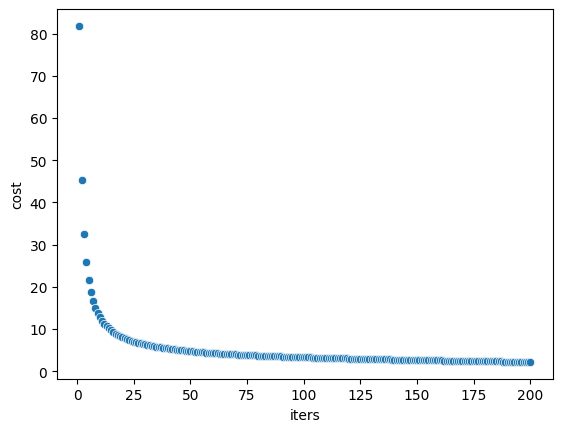

In [15]:
# run the coordinate descent for our train set
w_cd_ols,iter_ols,cost_array_ols=coordinate_descent_ols(y_train,X_train,w,tolerance)
output_path = '/content/drive/MyDrive/Sparse_PUFs/CD_final_weights.txt'
np.savetxt(output_path, w_cd_ols)

print(f"Weights saved to {output_path}")
# display
fig_ols=plot_cost_iter(cost_array_ols)
fig_ols

In [16]:
# Calculate predictions on the validation set
y_pred_val = X_val.dot(w_cd_ols)
print(w_cd_ols)
mse_val = np.mean((y_val - y_pred_val)**2)

print("MSE on Validation Set:", mse_val)


[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.67652994e+00
 8.04179324e-03 0.00000000e+00]
MSE on Validation Set: 63.20850155104902


In [17]:
r_square = r_squared(y_val, y_pred_val)
print(f"r_square: {r_square:.4f}")

r_square: 0.9950
